# FWI with Devito

Seismic inversion relies on two known parameters:

Field data - or also called recorded data. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

Initial velocity model. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

## True and smooth velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess.


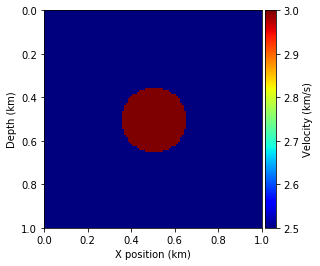

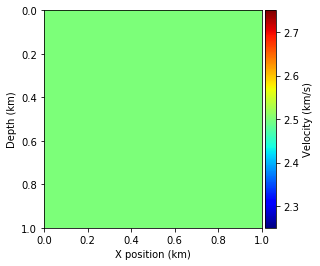

In [2]:
from examples.seismic import demo_model, plot_velocity

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbpml=40)

model0 = demo_model('circle-isotropic', vp=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbpml=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)

## Acquisition geometry

In [3]:
# Define acquisition geometry: source
import numpy as np
from examples.seismic import TimeAxis, RickerSource, Receiver

# Define time discretization according to grid spacing
t0 = 0.
tn = 1000.  # Simulation lasts 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)

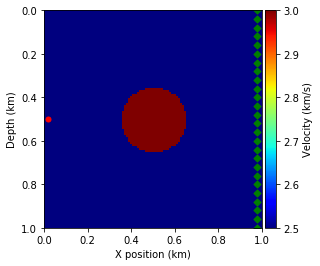

In [4]:
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, 0] = 20.  # 20m from the left end

# Initialize receivers for synthetic data
nreceivers = 101  # Number of receiver locations per shot 
rec = Receiver(name='rec', grid=model.grid, npoint=nreceivers, 
               time_range=time_range)
rec.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec.coordinates.data[:, 0] = 980. # 20m from the right end

# Plot acquisition geometry
plot_velocity(model, source=src.coordinates.data,
               receiver=rec.coordinates.data[::4, :])

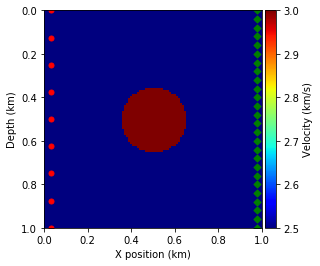

In [5]:
# Prepare the varying source locations sources
nshots = 9  # Number of shots to create gradient from
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations, receiver = rec.coordinates.data[::4,:])

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$, and a similar pre-defined gradient operator to compute the adjoint wavefield $\mathbf{v}$. The gradient operator provided by our solver utility also computes the correlation between the wavefields, allowing us to:

- Simulate the **forward wavefield** with the **background velocity model** to get the **synthetic data** and save the **full wavefield $\mathbf{u}$**
- Compute the **data residual**
- **Back-propagate** the data residual and compute on the fly **the gradient contribution** at each time step.

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface.

In [6]:
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, src, rec, space_order=4)

# Create FWI gradient kernel # Create 
from devito import Function, clear_cache, TimeFunction
import scipy
def fwi_gradient(m_in):    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='rec', grid=model.grid, time_range=time_range, coordinates=rec.coordinates.data)
    objective = 0.
    # Creat forward wavefield to reuse to avoid memory overload
    u0 = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4, save=time_range.num)
    for i in range(nshots):
        # Important: We force previous wavefields to be destroyed,
        # so that we may reuse the memory.
        clear_cache()
        # Update source location
        src.coordinates.data[0, :] = source_locations[i, :]
        # Generate synthetic data from true model
        true_d, _, _ = solver.forward(src=src, m=model.m)
        # Compute smooth data and full forward wavefield u0
        u0.data.fill(0.)
        smooth_d, _, _ = solver.forward(src=src, m=m_in, save=True, u=u0)
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        objective += .5*np.linalg.norm(residual.data.flatten()**2)
        solver.gradient(rec=residual, u=u0, m=m_in, grad=grad)
    return objective, grad.data

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the **gradient** alongside the **model perturbation** and the **effect of the *gradient update* on the *model* **.

In [7]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.m)
print('Objective value is %f ' % ff)

Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.05 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s


Objective value is 1065.389130 


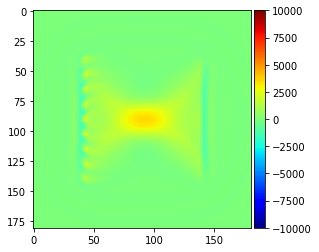

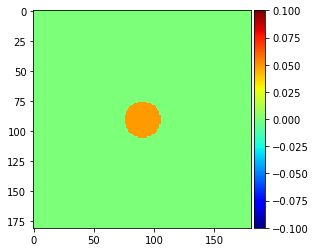

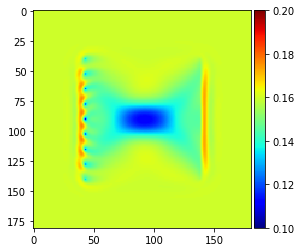

In [8]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(update, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.m.data - model.m.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .05 / np.max(update)
plot_image(model0.m.data - alpha*update, vmin=.1, vmax=.2, cmap="jet")

With an appropriate scaling factor, we will update the model in the correct direction.

In [9]:
# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(m, 1/3.5**2, 1/2**2)

In [10]:
# Run FWI with gradient descent
fwi_iterations = 5  # Number of outer FWI iterations
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current model estimate
    phi, direction = fwi_gradient(model0.m)
    # Store the history of the functional values
    history[i] = phi
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .005 / np.max(direction)
    # Update the model estimate and inforce minimum/maximum values
    model0.m.data[:] = apply_box_constraint(model0.m.data - alpha * direction)
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s


Objective value is 1065.389130 at iteration 1


Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.09 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.09 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s


Objective value is 757.835026 at iteration 2


Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s


Objective value is 508.540890 at iteration 3


Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s


Objective value is 320.797972 at iteration 4


Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.08 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.04 s
Operator `Forward` run in 0.04 s
Operator `Gradient` run in 0.07 s
Operator `Forward` run in 0.03 s
Operator `Forward` run in 0.03 s
Operator `Gradient` run in 0.07 s


Objective value is 186.716164 at iteration 5


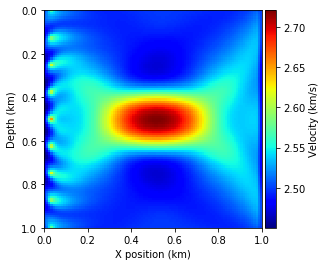

In [11]:
# First, update velocity from computed square slowness
nbpml = model.nbpml
model0.vp = np.sqrt(1. / model0.m.data[nbpml:-nbpml, nbpml:-nbpml])

# Plot inverted velocity model
plot_velocity(model0)

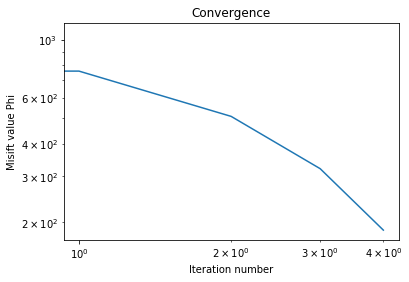

In [12]:
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()